# Difference in Difference Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

final_dataset = pd.read_csv("/Users/alina/Desktop/final_dataset.csv")
final_dataset.head()

,County_FIPS_x,County,state_FIPS,State,pop_Year,pop_Population,pop_merge_indicator,pov_poverty_rate_percent,pov_merge_indicator,minc_median_income_USD_2021,...,FIPS|YEAR,County_FIPS_y,mort_year,mort_overdose_deaths,mort_merge_indicator,predicted_overdose_deaths_stochastic,_merge,pop_log_population,grams_morphine_per_cap,overdose_deaths_per_cap
0,1001,AUTAUGA,1,AL,2021,59203,both,10.7,both,"66,444",...,01001|2006,NaN,NaN,12.184398,Random Forest Predicted Values,12.184398,both,10.988727,0.288846,0.000203
1,1001,AUTAUGA,1,AL,2021,59203,both,10.7,both,"66,444",...,01001|2007,NaN,NaN,11.447327,Random Forest Predicted Values,11.447327,both,10.988727,0.323596,0.000186
2,1001,AUTAUGA,1,AL,2021,59203,both,10.7,both,"66,444",...,01001|2008,NaN,NaN,12.359647,Random Forest Predicted Values,12.359647,both,10.988727,0.367991,0.000203
3,1001,AUTAUGA,1,AL,2021,59203,both,10.7,both,"66,444",...,01001|2009,NaN,NaN,13.375727,Random Forest Predicted Values,13.375727,both,10.988727,0.412844,0.000220
4,1001,AUTAUGA,1,AL,2021,59203,both,10.7,both,"66,444",...,01001|2010,NaN,NaN,11.336020,Random Forest Predicted Values,11.336020,both,10.988727,0.442263,0.000186


# Florida

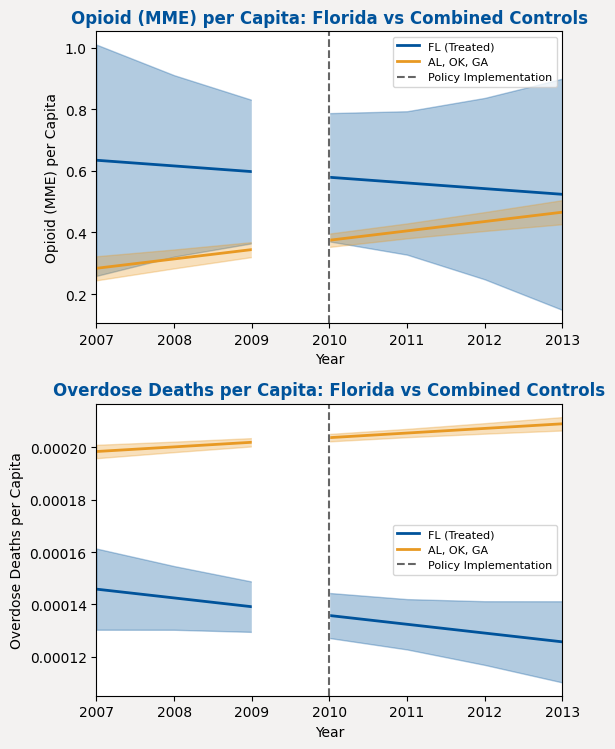

In [8]:
def add_policy_year_break(ax, break_year_start, break_year_end):
    ax.axvspan(
        break_year_start, break_year_end, color="white", zorder=2, edgecolor=None
    )
    return ax


def create_combined_did_charts_florida(final_dataset, control_states):
    final_dataset["opioid_YEAR"] = pd.to_numeric(
        final_dataset["opioid_YEAR"], errors="coerce"
    )
    final_dataset = final_dataset.dropna(subset=["opioid_YEAR"])

    final_dataset = final_dataset[
        (final_dataset["opioid_YEAR"] >= 2007) & (final_dataset["opioid_YEAR"] <= 2013)
    ]

    duke_colors = {
        "blue": "#00539B",
        "gray": "#666666",
        "orange": "#E89923",
        "background": "#F3F2F1",
    }

    florida_data = final_dataset[final_dataset["State"] == "FL"]

    fl_aggregated = (
        florida_data.groupby("opioid_YEAR")
        .agg(
            total_population=("pop_Population", "sum"),
            total_morphine=("opioid_morphine_equivalent_g", "sum"),
            total_deaths=("mort_overdose_deaths", "sum"),
        )
        .reset_index()
    )
    fl_aggregated["morphine_per_capita"] = (
        fl_aggregated["total_morphine"] / fl_aggregated["total_population"]
    )
    fl_aggregated["deaths_per_capita"] = (
        fl_aggregated["total_deaths"] / fl_aggregated["total_population"]
    )

    morphine_model = smf.ols(
        "morphine_per_capita ~ opioid_YEAR", data=fl_aggregated
    ).fit()
    morphine_predictions = morphine_model.get_prediction(fl_aggregated).summary_frame()
    fl_aggregated["morphine_predicted"] = morphine_predictions["mean"]
    fl_aggregated["morphine_ci_low"] = morphine_predictions["mean_ci_lower"]
    fl_aggregated["morphine_ci_high"] = morphine_predictions["mean_ci_upper"]

    deaths_model = smf.ols("deaths_per_capita ~ opioid_YEAR", data=fl_aggregated).fit()
    deaths_predictions = deaths_model.get_prediction(fl_aggregated).summary_frame()
    fl_aggregated["deaths_predicted"] = deaths_predictions["mean"]
    fl_aggregated["deaths_ci_low"] = deaths_predictions["mean_ci_lower"]
    fl_aggregated["deaths_ci_high"] = deaths_predictions["mean_ci_upper"]

    control_data = final_dataset[final_dataset["State"].isin(control_states)]
    control_aggregated = (
        control_data.groupby("opioid_YEAR")
        .agg(
            total_population=("pop_Population", "sum"),
            total_morphine=("opioid_morphine_equivalent_g", "sum"),
            total_deaths=("mort_overdose_deaths", "sum"),
        )
        .reset_index()
    )
    control_aggregated["morphine_per_capita"] = (
        control_aggregated["total_morphine"] / control_aggregated["total_population"]
    )
    control_aggregated["deaths_per_capita"] = (
        control_aggregated["total_deaths"] / control_aggregated["total_population"]
    )

    control_morphine_model = smf.ols(
        "morphine_per_capita ~ opioid_YEAR", data=control_aggregated
    ).fit()
    control_morphine_predictions = control_morphine_model.get_prediction(
        control_aggregated
    ).summary_frame()
    control_aggregated["morphine_predicted"] = control_morphine_predictions["mean"]
    control_aggregated["morphine_ci_low"] = control_morphine_predictions[
        "mean_ci_lower"
    ]
    control_aggregated["morphine_ci_high"] = control_morphine_predictions[
        "mean_ci_upper"
    ]

    control_deaths_model = smf.ols(
        "deaths_per_capita ~ opioid_YEAR", data=control_aggregated
    ).fit()
    control_deaths_predictions = control_deaths_model.get_prediction(
        control_aggregated
    ).summary_frame()
    control_aggregated["deaths_predicted"] = control_deaths_predictions["mean"]
    control_aggregated["deaths_ci_low"] = control_deaths_predictions["mean_ci_lower"]
    control_aggregated["deaths_ci_high"] = control_deaths_predictions["mean_ci_upper"]

    fig, axes = plt.subplots(2, 1, figsize=(6, 8), facecolor=duke_colors["background"])

    # Chart 1: Morphine per capita
    axes[0].plot(
        fl_aggregated["opioid_YEAR"],
        fl_aggregated["morphine_predicted"],
        color=duke_colors["blue"],
        label="FL (Treated)",
        linewidth=2,
    )
    axes[0].fill_between(
        fl_aggregated["opioid_YEAR"],
        fl_aggregated["morphine_ci_low"],
        fl_aggregated["morphine_ci_high"],
        color=duke_colors["blue"],
        alpha=0.3,
    )
    axes[0].plot(
        control_aggregated["opioid_YEAR"],
        control_aggregated["morphine_predicted"],
        color=duke_colors["orange"],
        label="AL, OK, GA",
        linewidth=2,
    )
    axes[0].fill_between(
        control_aggregated["opioid_YEAR"],
        control_aggregated["morphine_ci_low"],
        control_aggregated["morphine_ci_high"],
        color=duke_colors["orange"],
        alpha=0.3,
    )
    axes[0] = add_policy_year_break(axes[0], 2009, 2010)
    axes[0].axvline(
        x=2010,
        color=duke_colors["gray"],
        linestyle="--",
        linewidth=1.5,
        label="Policy Implementation",
    )
    axes[0].set_title(
        "Opioid (MME) per Capita: Florida vs Combined Controls",
        fontsize=12,
        weight="bold",
        color=duke_colors["blue"],
    )

    axes[0].legend(
        loc="upper right",
        fontsize=8,
        framealpha=0.8,
    )

    axes[0].set_xlim([2007, 2013])
    axes[0].set_xlabel("Year", fontsize=10, color="black", weight="normal")
    axes[0].set_ylabel(
        "Opioid (MME) per Capita", fontsize=10, color="black", weight="normal"
    )

    # Chart 2: Overdose deaths per capita
    axes[1].plot(
        fl_aggregated["opioid_YEAR"],
        fl_aggregated["deaths_predicted"],
        color=duke_colors["blue"],
        label="FL (Treated)",
        linewidth=2,
    )
    axes[1].fill_between(
        fl_aggregated["opioid_YEAR"],
        fl_aggregated["deaths_ci_low"],
        fl_aggregated["deaths_ci_high"],
        color=duke_colors["blue"],
        alpha=0.3,
    )
    axes[1].plot(
        control_aggregated["opioid_YEAR"],
        control_aggregated["deaths_predicted"],
        color=duke_colors["orange"],
        label="AL, OK, GA",
        linewidth=2,
    )
    axes[1].fill_between(
        control_aggregated["opioid_YEAR"],
        control_aggregated["deaths_ci_low"],
        control_aggregated["deaths_ci_high"],
        color=duke_colors["orange"],
        alpha=0.3,
    )
    axes[1] = add_policy_year_break(axes[1], 2009, 2010)
    axes[1].axvline(
        x=2010,
        color=duke_colors["gray"],
        linestyle="--",
        linewidth=1.5,
        label="Policy Implementation",
    )
    axes[1].set_title(
        "Overdose Deaths per Capita: Florida vs Combined Controls",
        fontsize=12,
        weight="bold",
        color=duke_colors["blue"],
    )

    axes[1].legend(
        loc="center right",
        fontsize=8,
        framealpha=0.8,
    )

    axes[1].set_xlim([2007, 2013])
    axes[1].set_xlabel("Year", fontsize=10, color="black", weight="normal")
    axes[1].set_ylabel(
        "Overdose Deaths per Capita", fontsize=10, color="black", weight="normal"
    )

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


control_states = ["AL", "OK", "GA"]
create_combined_did_charts_florida(
    final_dataset=final_dataset, control_states=control_states
)

# Washington

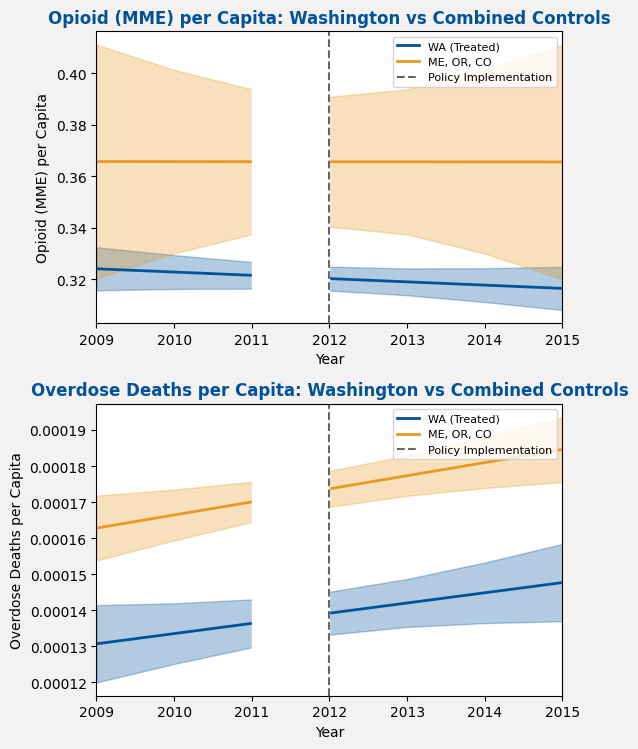

In [12]:
def add_policy_year_break(ax, break_year_start, break_year_end):
    ax.axvspan(
        break_year_start, break_year_end, color="white", zorder=2, edgecolor=None
    )
    return ax


def create_combined_did_charts_washington(final_dataset, control_states):
    final_dataset["opioid_YEAR"] = pd.to_numeric(
        final_dataset["opioid_YEAR"], errors="coerce"
    )
    final_dataset = final_dataset.dropna(subset=["opioid_YEAR"])

    final_dataset = final_dataset[
        (final_dataset["opioid_YEAR"] >= 2009) & (final_dataset["opioid_YEAR"] <= 2015)
    ]

    duke_colors = {
        "blue": "#00539B",
        "gray": "#666666",
        "orange": "#E89923",
        "background": "#F3F2F1",
    }

    washington_data = final_dataset[final_dataset["State"] == "WA"]

    wa_aggregated = (
        washington_data.groupby("opioid_YEAR")
        .agg(
            total_population=("pop_Population", "sum"),
            total_morphine=("opioid_morphine_equivalent_g", "sum"),
            total_deaths=("mort_overdose_deaths", "sum"),
        )
        .reset_index()
    )
    wa_aggregated["morphine_per_capita"] = (
        wa_aggregated["total_morphine"] / wa_aggregated["total_population"]
    )
    wa_aggregated["deaths_per_capita"] = (
        wa_aggregated["total_deaths"] / wa_aggregated["total_population"]
    )

    morphine_model = smf.ols(
        "morphine_per_capita ~ opioid_YEAR", data=wa_aggregated
    ).fit()
    morphine_predictions = morphine_model.get_prediction(wa_aggregated).summary_frame()
    wa_aggregated["morphine_predicted"] = morphine_predictions["mean"]
    wa_aggregated["morphine_ci_low"] = morphine_predictions["mean_ci_lower"]
    wa_aggregated["morphine_ci_high"] = morphine_predictions["mean_ci_upper"]

    deaths_model = smf.ols("deaths_per_capita ~ opioid_YEAR", data=wa_aggregated).fit()
    deaths_predictions = deaths_model.get_prediction(wa_aggregated).summary_frame()
    wa_aggregated["deaths_predicted"] = deaths_predictions["mean"]
    wa_aggregated["deaths_ci_low"] = deaths_predictions["mean_ci_lower"]
    wa_aggregated["deaths_ci_high"] = deaths_predictions["mean_ci_upper"]

    control_data = final_dataset[final_dataset["State"].isin(control_states)]
    control_aggregated = (
        control_data.groupby("opioid_YEAR")
        .agg(
            total_population=("pop_Population", "sum"),
            total_morphine=("opioid_morphine_equivalent_g", "sum"),
            total_deaths=("mort_overdose_deaths", "sum"),
        )
        .reset_index()
    )
    control_aggregated["morphine_per_capita"] = (
        control_aggregated["total_morphine"] / control_aggregated["total_population"]
    )
    control_aggregated["deaths_per_capita"] = (
        control_aggregated["total_deaths"] / control_aggregated["total_population"]
    )

    control_morphine_model = smf.ols(
        "morphine_per_capita ~ opioid_YEAR", data=control_aggregated
    ).fit()
    control_morphine_predictions = control_morphine_model.get_prediction(
        control_aggregated
    ).summary_frame()
    control_aggregated["morphine_predicted"] = control_morphine_predictions["mean"]
    control_aggregated["morphine_ci_low"] = control_morphine_predictions[
        "mean_ci_lower"
    ]
    control_aggregated["morphine_ci_high"] = control_morphine_predictions[
        "mean_ci_upper"
    ]

    control_deaths_model = smf.ols(
        "deaths_per_capita ~ opioid_YEAR", data=control_aggregated
    ).fit()
    control_deaths_predictions = control_deaths_model.get_prediction(
        control_aggregated
    ).summary_frame()
    control_aggregated["deaths_predicted"] = control_deaths_predictions["mean"]
    control_aggregated["deaths_ci_low"] = control_deaths_predictions["mean_ci_lower"]
    control_aggregated["deaths_ci_high"] = control_deaths_predictions["mean_ci_upper"]

    fig, axes = plt.subplots(2, 1, figsize=(6, 8), facecolor=duke_colors["background"])

    # Chart 1: Morphine per capita
    axes[0].plot(
        wa_aggregated["opioid_YEAR"],
        wa_aggregated["morphine_predicted"],
        color=duke_colors["blue"],
        label="WA (Treated)",
        linewidth=2,
    )
    axes[0].fill_between(
        wa_aggregated["opioid_YEAR"],
        wa_aggregated["morphine_ci_low"],
        wa_aggregated["morphine_ci_high"],
        color=duke_colors["blue"],
        alpha=0.3,
    )
    axes[0].plot(
        control_aggregated["opioid_YEAR"],
        control_aggregated["morphine_predicted"],
        color=duke_colors["orange"],
        label="ME, OR, CO",
        linewidth=2,
    )
    axes[0].fill_between(
        control_aggregated["opioid_YEAR"],
        control_aggregated["morphine_ci_low"],
        control_aggregated["morphine_ci_high"],
        color=duke_colors["orange"],
        alpha=0.3,
    )
    axes[0] = add_policy_year_break(axes[0], 2011, 2012)
    axes[0].axvline(
        x=2012,
        color=duke_colors["gray"],
        linestyle="--",
        linewidth=1.5,
        label="Policy Implementation",
    )
    axes[0].set_title(
        "Opioid (MME) per Capita: Washington vs Combined Controls",
        fontsize=12,
        weight="bold",
        color=duke_colors["blue"],
    )

    axes[0].legend(
        loc="upper right",
        fontsize=8,
        framealpha=0.8,
    )

    axes[0].set_xlim([2009, 2015])
    axes[0].set_xlabel("Year", fontsize=10, color="black", weight="normal")
    axes[0].set_ylabel(
        "Opioid (MME) per Capita", fontsize=10, color="black", weight="normal"
    )

    # Chart 2: Overdose deaths per capita
    axes[1].plot(
        wa_aggregated["opioid_YEAR"],
        wa_aggregated["deaths_predicted"],
        color=duke_colors["blue"],
        label="WA (Treated)",
        linewidth=2,
    )
    axes[1].fill_between(
        wa_aggregated["opioid_YEAR"],
        wa_aggregated["deaths_ci_low"],
        wa_aggregated["deaths_ci_high"],
        color=duke_colors["blue"],
        alpha=0.3,
    )
    axes[1].plot(
        control_aggregated["opioid_YEAR"],
        control_aggregated["deaths_predicted"],
        color=duke_colors["orange"],
        label="ME, OR, CO",
        linewidth=2,
    )
    axes[1].fill_between(
        control_aggregated["opioid_YEAR"],
        control_aggregated["deaths_ci_low"],
        control_aggregated["deaths_ci_high"],
        color=duke_colors["orange"],
        alpha=0.3,
    )
    axes[1] = add_policy_year_break(axes[1], 2011, 2012)
    axes[1].axvline(
        x=2012,
        color=duke_colors["gray"],
        linestyle="--",
        linewidth=1.5,
        label="Policy Implementation",
    )
    axes[1].set_title(
        "Overdose Deaths per Capita: Washington vs Combined Controls",
        fontsize=12,
        weight="bold",
        color=duke_colors["blue"],
    )

    axes[1].legend(
        loc="upper right",
        fontsize=8,
        framealpha=0.8,
    )

    axes[1].set_xlim([2009, 2015])
    axes[1].set_xlabel("Year", fontsize=10, color="black", weight="normal")
    axes[1].set_ylabel(
        "Overdose Deaths per Capita", fontsize=10, color="black", weight="normal"
    )

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


control_states = ["ME", "OR", "CO"]
create_combined_did_charts_washington(
    final_dataset=final_dataset, control_states=control_states
)